In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

data_dir = "../data/processed/"

In [14]:
# data loading 
train_file = np.loadtxt(data_dir+"windowed_train_FD001.txt",delimiter=",")
test_file = np.loadtxt(data_dir +"standardized_test_FD001.txt",delimiter=",")
train_file_stan = np.loadtxt(data_dir+"standardized_train_FD001.txt",delimiter=",")

train_file_auto = np.loadtxt(data_dir+"windowed_aefeaturestrain1.txt",delimiter=",")
test_file_auto = np.loadtxt(data_dir+"non-linear_features_test1.txt",delimiter=",")

train_x = train_file[:,2:]
train_y = train_file[:,1]

train_x_stan = train_file_stan[:,2:]
train_units = train_file_stan[:,0]
train_y_stan = train_file_stan[:,1]

test_units = test_file[:,0]
test_x = test_file[:,2:]
test_y = test_file[:,1]

test_units_ae = test_file_auto[:,0]
test_x_ae = test_file_auto[:,2:]
test_y_ae = test_file_auto[:,1]

train_x_auto = train_file_auto[:,2:]
train_units = train_file_auto[:,0]
train_y_auto = train_file_auto[:,1]




In [4]:
N_tw = 50
num_samples = int(train_file.shape[0]/N_tw)
num_features = 24
num_features_ae = 14
print(num_samples)

data_x = torch.zeros(num_samples,N_tw,num_features)
data_y = torch.zeros(num_samples,N_tw,1)

data_x_ae = torch.zeros(num_samples,N_tw,num_features_ae)
data_y_ae = torch.zeros(num_samples,N_tw,1)

for i in range(num_samples):
    for t in range(N_tw):
        data_y[i][t][0] = torch.tensor(train_y[i*N_tw+t])
        data_x[i][t][:] = torch.tensor(train_x[i*N_tw+t,:])

        data_y_ae[i][t][0] = torch.tensor(train_y_auto[i*N_tw+t])
        data_x_ae[i][t][:] = torch.tensor(train_x_auto[i*N_tw+t,:])
        # for j in range(num_features):
        #     data_x[i][t][0][j] = train_x[i*N_tw+t,j]

15731


In [5]:
class EngineDataset(Dataset):
    def __init__(self,data_x,data_y):
        self.x = data_x
        self.y = data_y

    def __len__(self):
        return self.x.size()[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
batch_size = 128
train_data = EngineDataset(data_x, data_y)
train_data_ae = EngineDataset(data_x_ae,data_y_ae)
print(train_data.__len__())
print(train_data.x.size())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
train_loader_ae = DataLoader(train_data_ae,shuffle=True,batch_size =batch_size,drop_last=True)
print(next(iter(train_loader))[0].size())

15731
torch.Size([15731, 50, 24])
torch.Size([128, 50, 24])


In [7]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
#Create Neural Net
class GRUNet(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers,drop_prob=0.5):
        super(GRUNet,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #batch_first = True : input dims are (batch_size,seq_length,n_features)
        self.gru = nn.GRU(input_dim,hidden_dim,n_layers,batch_first=True,dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.relu = nn.ReLU()

    def forward(self,x,h):
        out,h = self.gru(x,h)
        out = self.fc(self.relu(out[:,-1]))

        return out,h

    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers,batch_size,self.hidden_dim).zero_().to(device)
        
        return hidden

In [22]:
#Custom loss function
class WeightedLoss(nn.Module):
    def __init__(self,weight=1):
        super(WeightedLoss,self).__init__()
        self.weight = weight

    def forward(self,output,target):
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(output,target)
        mask = output > target

        #boost loss for samples that overpredict RUL
        high_cost = self.weight*( loss * mask )

        loss = torch.mean(loss + high_cost)
    
        # return loss
        return loss

In [23]:
def train(train_loader, learn_rate, loss_fn = nn.MSELoss(), hidden_dim=256, EPOCHS=5):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].size()[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    batch_size = train_loader.batch_size
    
    # Defining loss function and optimizer
    criterion = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of GRU model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data

            model.zero_grad()
            label = label[:,-1]
            
            out, h = model(x.to(device).float(), h)

            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.process_time()        
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Epoch Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [32]:
lr = 0.001
loss_fn = WeightedLoss(weight=1000)
gru_model = train(train_loader,lr,loss_fn=loss_fn,EPOCHS=50)
gru_model_ae = train(train_loader_ae,lr,EPOCHS=100)

Starting Training of GRU model
Epoch 1/50 Done, Total Loss: 2.7353719348301655
Epoch Time Elapsed: 1.0 seconds
Epoch 2/50 Done, Total Loss: 0.5572557373613608
Epoch Time Elapsed: 0.6875 seconds
Epoch 3/50 Done, Total Loss: 0.551311548371784
Epoch Time Elapsed: 0.671875 seconds
Epoch 4/50 Done, Total Loss: 0.4706017695000914
Epoch Time Elapsed: 0.671875 seconds
Epoch 5/50 Done, Total Loss: 0.4745696814822369
Epoch Time Elapsed: 0.6875 seconds
Epoch 6/50 Done, Total Loss: 0.4021062408802939
Epoch Time Elapsed: 0.6875 seconds
Epoch 7/50 Done, Total Loss: 0.38595556247918333
Epoch Time Elapsed: 0.703125 seconds
Epoch 8/50 Done, Total Loss: 0.3006703074349732
Epoch Time Elapsed: 0.6875 seconds
Epoch 9/50 Done, Total Loss: 0.34188855121858786
Epoch Time Elapsed: 0.6875 seconds
Epoch 10/50 Done, Total Loss: 0.2862843116287325
Epoch Time Elapsed: 0.703125 seconds
Epoch 11/50 Done, Total Loss: 0.2988296824156261
Epoch Time Elapsed: 0.703125 seconds
Epoch 12/50 Done, Total Loss: 0.29704612982077

In [33]:
def evaluate(model, test_x, test_y, test_units):
    model.eval()
    outputs = []
    targets = []
    errors = []
    start_time = time.process_time()

    for i in range(1,100+1):
        ind = np.where(test_units == i)
        unit_x = test_x[ind,:]
        unit_y = test_y[ind]

        inp = torch.from_numpy(unit_x)
        labs = torch.from_numpy(unit_y)
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        out = 65*(out+1)
        target = 65*(labs[-1]+1)

        outputs.append(out)
        targets.append(target)
        print(out)
        errors.append((out - target).cpu().detach().numpy())

    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    sMAPE = 0
    MAE = 0
    for i in range(len(outputs)):
        MAE += abs(outputs[i] - targets[i])/len(outputs)
        
        # sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print(f"MAE: {MAE.item()}")

    return errors


In [34]:
# print("Training Data: ")
# errors_train = evaluate(gru_model,train_x_stan,train_y_stan,train_units)
# errors_train = np.array(errors_train)[:,:,0]

print("Test Data: ")
errors_test = evaluate(gru_model,test_x,test_y,test_units)
errors_test = np.array(errors_test)[:,:,0]

print("Test Data AE: ")
errors_test_ae = evaluate(gru_model_ae,test_x_ae,test_y,test_units_ae)
errors_test_ae = np.array(errors_test_ae)[:,:,0]


Test Data: 
tensor([[65.3649]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[93.9874]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[37.4992]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[59.1660]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[65.8477]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[89.8024]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[83.0670]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[58.4901]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[98.6320]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[49.3640]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[72.0076]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[81.5938]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[52.5520]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[88.2361]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[80.1211]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[72.9945]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[28.

96


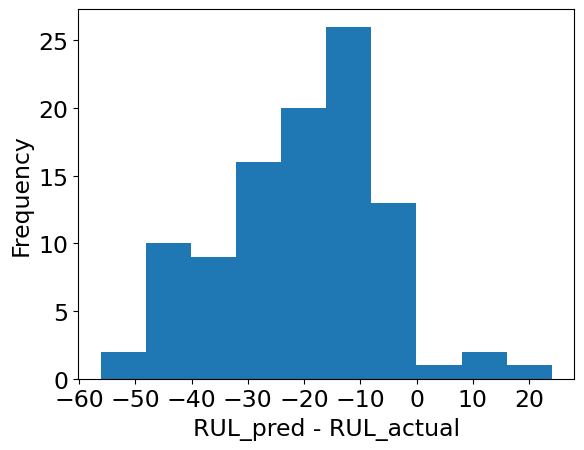

In [35]:
# plt.hist(errors_train)
# plt.xlabel('RUL_pred - RUL_actual')
# plt.ylabel('Frequency')


plt.figure()
plt.hist(errors_test)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('RUL_pred - RUL_actual',fontsize=17)
plt.ylabel('Frequency',fontsize=17)


print(np.sum(errors_test < 0))